# Prompts for Generation

In [1]:
%load_ext autoreload
%autoreload 2
from utils import dpo_dependencies
from utils import base_dependencies
import random
import pandas as pd
import numpy as np
import shutil

c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tmp = dpo_dependencies.lhapa_aggregate()
print(len(tmp))
print(tmp[0])

11078
Neben der Anklage zu Korruptionsverdacht bei der Bundeswohnungs-Privatisierung (Buwog und andere Wohnbaugesellschaften) und dem Linzer Bürohaus Terminal Tower wurden auch Anklagen zur Causa Telekom-Valora-Parteienfinanzierung sowie ein Betrugsvorwurf rund um Walter Meischbergers Villa in den Prozess aufgenommen.


In [3]:
# Combine capito sentence files and leftover APA sentences file
tmp = dpo_dependencies.aggregate_dpo_possibilities()

5355 apa sentences, 11078 lhapa sentences.
filtering based on in apa...
5355 apa sentences, 11046 lhapa sentences.
filtering based on length...
5355 apa sentences, 11011 lhapa sentences.
filtering based on non-German...
5355 apa sentences, 11010 lhapa sentences.
filtering based on multiple sentences...
4884 apa sentences, 10194 lhapa sentences.


len apa:  4884


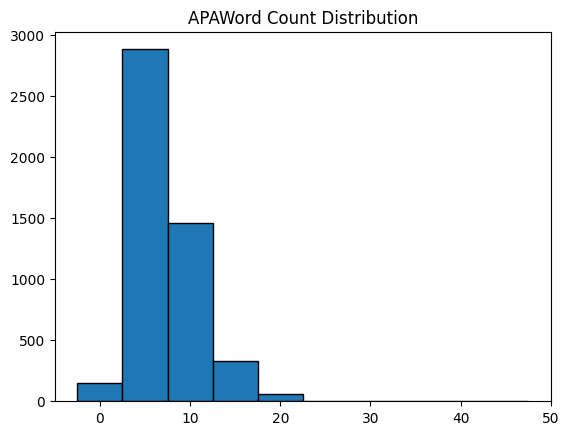

len lhapa:  10194


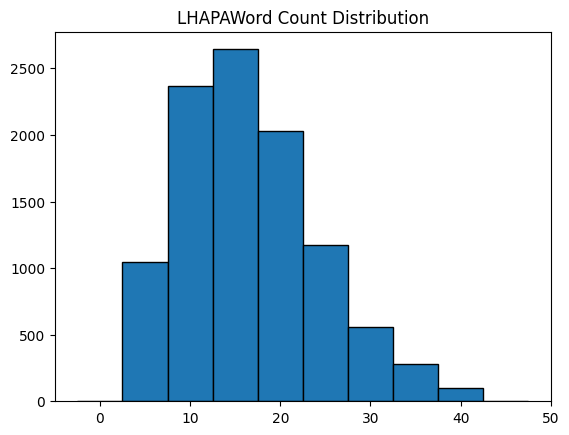

In [4]:
# Plot distribution of sentence length
dpo_dependencies.plot_dpo_possibility_dist()

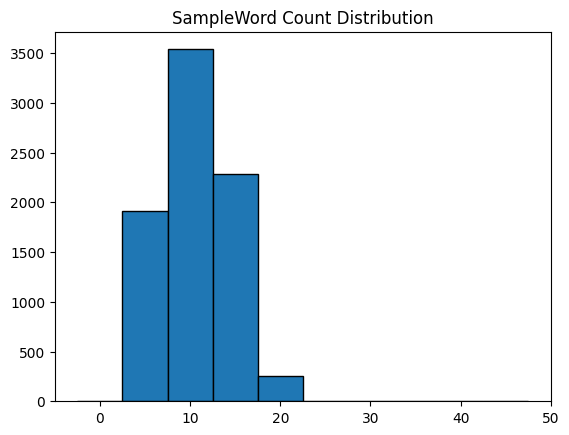

3200 4800


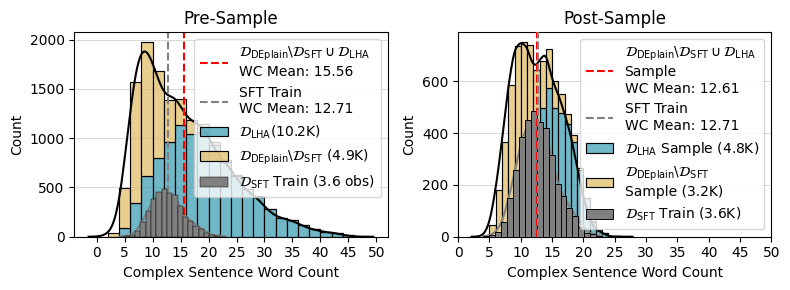

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

full_dpo_sample, apa_dpo_sample, lha_dpo_sample = dpo_dependencies.draw_to_dpo_sample(5, 8000, 0.4)

def push_to_generate_space(df, fname):
    random.seed(5)
    df['prompt'] = df['original'].apply(lambda x: base_dependencies.select_prompt(x, "dpo_pair_generation", "rand", []))
    df.to_json(f'outputs/dpo/{fname}.jsonl', orient='records', lines=True)

push_to_generate_space(full_dpo_sample, 'for_inference_newsample')

# cull sentences that already have pairs from before 
#already_found = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/manually_approved_20250128.jsonl'))
#tmp = pd.merge(full_dpo_sample, already_found, on='original', how='left', indicator=True)
#tmp = tmp[tmp['_merge'] != 'both']
#tmp = tmp[['original']]
#push_to_generate_space(tmp, 'for_inference')

def dpo_original_sent_dist(apa_samp_wcs, lha_samp_wcs, winning=False):

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    _, apa_orig_wcs, _, lha_orig_wcs = dpo_dependencies.access_sentences_and_wcs()

    train_orig_sentences = [instance_dict['original'] for instance_dict in base_dependencies.load_jsonl('data/sft_train.jsonl')]
    train_orig_wcs = base_dependencies.wcs(train_orig_sentences)
    labels = [f'Leftover DEplain ({len(apa_orig_wcs)} obs)', f'Capito ({len(lha_orig_wcs)} obs)']

    print(len(apa_samp_wcs), len(lha_samp_wcs))

    candidates = pd.DataFrame({
        'wc': apa_orig_wcs + lha_orig_wcs,
        'source': ['Leftover SFT'] * len(apa_orig_wcs) + ['LHA Paper'] * len(lha_orig_wcs)
    })

    cb_palette = ['#e1be6a', '#40a0b6']
    axs[0].grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=0.7, zorder=-1)
    sns.histplot(candidates, x = 'wc', hue='source', kde=False, multiple='stack', ax=axs[0], bins=22, alpha=0.75, label='tmp', palette=cb_palette, zorder=2)
    axs[1].grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=0.7, zorder=-1)
    kde = sns.kdeplot(candidates['wc'], ax=axs[0], color='black', label='')
    y = kde.get_lines()[-1].get_ydata()
    x = kde.get_lines()[-1].get_xdata()
    scale = len(candidates['wc']) * np.diff(np.histogram_bin_edges(candidates['wc'], bins=22))[0]
    kde.lines[-1].set_ydata(y * scale)
    sns.histplot(train_orig_wcs, color='grey', kde=True, ax=axs[0], bins=20, alpha=1, label=r'$\mathcal{D}_{\text{SFT}}$' + f' Train ({len(train_orig_wcs)/1000:.1f} obs)', zorder=3)
    axs[0].axvline(np.mean(apa_orig_wcs + lha_orig_wcs), color='red', linestyle='--', label=r'$\mathcal{D}_{\text{DEplain}} \backslash \mathcal{D}_{\text{SFT}} \cup \mathcal{D}_{\text{LHA}}$' + f'\nWC Mean: {np.mean(apa_orig_wcs + lha_orig_wcs):.2f}')
    axs[0].axvline(np.mean(train_orig_wcs), color='grey', linestyle='--', label=f'SFT Train\nWC Mean: {np.mean(train_orig_wcs):.2f}')
    axs[0].set_xlabel('Complex Sentence Word Count')
    axs[0].set_ylabel('Count')
    axs[0].set_title('Pre-Sample')
    axs[0].legend()
    axs[0].set_xticks(np.arange(0, 55, 5))

    handles, labels = axs[0].get_legend_handles_labels()
    labels[2] = r'$\mathcal{D}_{\text{LHA}}$' + f'({len(lha_orig_wcs)/1000:.1f}K)'
    labels[3] = r'$\mathcal{D}_{\text{DEplain}} \backslash \mathcal{D}_{\text{SFT}}$' + f' ({len(apa_orig_wcs)/1000:.1f}K)'
    axs[0].legend(handles, labels)

    candidates = pd.DataFrame({
        'wc': apa_samp_wcs + lha_samp_wcs,
        'source': ['Leftover SFT'] * len(apa_samp_wcs) + ['LHA Paper'] * len(lha_samp_wcs)
    })

    if winning==True:
        team_pairs, team_skips = dpo_dependencies.load_pair_creation_files('team_pairs_20250220')
        auto_pairs = pd.read_json('outputs/dpo/pair_creation/auto_pairs.jsonl', lines=True)

        winning_pairs = pd.DataFrame({
            'wc': base_dependencies.wcs(team_pairs['original']) + base_dependencies.wcs(auto_pairs['original']),
            'source': ['Team Pairs'] * len(team_pairs) + ['Auto Pairs'] * len(auto_pairs)
        })

    sns.histplot(candidates, x = 'wc', hue='source', kde=False, multiple='stack', ax=axs[1], bins=22, alpha=0.75, label='tmp', palette=cb_palette, zorder=2)
    kde = sns.kdeplot(candidates['wc'], ax=axs[1], color='black', label='')
    y = kde.get_lines()[-1].get_ydata()
    x = kde.get_lines()[-1].get_xdata()
    scale = len(candidates['wc']) * np.diff(np.histogram_bin_edges(candidates['wc'], bins=22))[0]
    kde.lines[-1].set_ydata(y * scale)
    sns.histplot(train_orig_wcs, color='grey', kde=True, ax=axs[1], bins=20, alpha=1, label='SFT Train', zorder=3)


    if winning==True:
        sns.histplot(winning_pairs, x = 'wc', hue='source', kde=True, multiple='stack', ax=axs[1], bins=22, alpha=0.75, label='tmp', palette=cb_palette)

    axs[1].axvline(np.mean(apa_samp_wcs + lha_samp_wcs), color='red', linestyle='--', label=r'$\mathcal{D}_{\text{DEplain}} \backslash \mathcal{D}_{\text{SFT}} \cup \mathcal{D}_{\text{LHA}}$' f'\nSample\nWC Mean: {np.mean(apa_samp_wcs + lha_samp_wcs):.2f}', zorder=4)
    axs[1].axvline(np.mean(train_orig_wcs), color='grey', linestyle='--', label=f'SFT Train\nWC Mean: {np.mean(train_orig_wcs):.2f}', zorder=4)
    axs[1].set_xlabel('Complex Sentence Word Count')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Post-Sample')
    axs[1].legend()
    axs[1].set_xticks(np.arange(0, 55, 5))

    handles, labels = axs[1].get_legend_handles_labels()
    labels[2] = r'$\mathcal{D}_{\text{LHA}}$' + f' Sample ({len(lha_samp_wcs)/1000:.1f}K)'
    labels[3] = r'$\mathcal{D}_{\text{DEplain}} \backslash \mathcal{D}_{\text{SFT}}$' + f'\nSample ({len(apa_samp_wcs)/1000:.1f}K)'  #$\mathcal{D}_{\text{\textsc{DEPlain}}} \backslash \mathcal{D}_{\text{SFT}}$
    labels[4] = r'$\mathcal{D}_{\text{SFT}}$' + f' Train ({len(train_orig_wcs)/1000:.1f}K)'
    if winning==True:
        labels[5] = f'Human Pairs ({len(team_pairs)} obs)'
        labels[6] = f'Auto Pairs ({len(auto_pairs)} obs)'
    axs[1].legend(handles, labels)


    plt.tight_layout()

    plt.savefig('figures/prefpair_infsent_sampling.png', dpi=800)
    plt.show()

dpo_original_sent_dist(base_dependencies.wcs(apa_dpo_sample), base_dependencies.wcs(lha_dpo_sample))

3200 4800


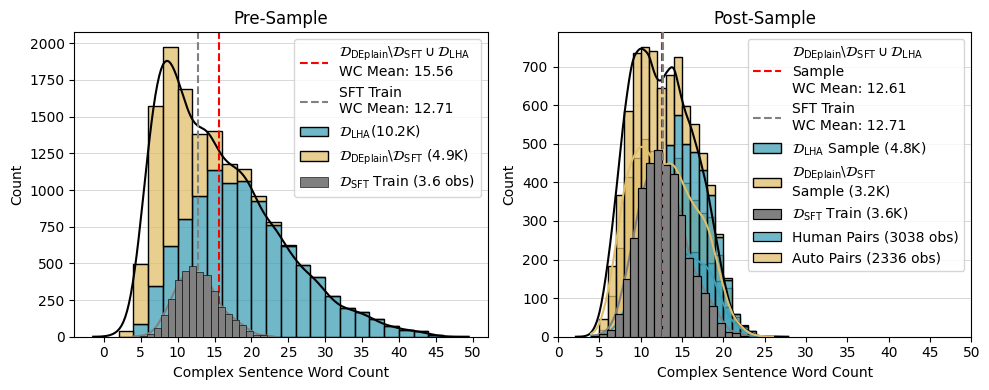

In [6]:
dpo_original_sent_dist(base_dependencies.wcs(apa_dpo_sample), base_dependencies.wcs(lha_dpo_sample), True)

------------------------------------------------------------------

Before proceeding, run predpoinference.py to create english translations of the sentences used for DPO. This will help for quality assurance of DPO pairs.

Then, use dpo_inference_wrapper.py to pass the sentences inside outputs/dpo/for_inference_w_english.jsonl to the chosen model checkpoint(s) post-SFT.

------------------------------------------------------------------